In [1]:
#Парсинг
import requests
from bs4 import BeautifulSoup

In [2]:
import pandas as pd
import numpy as np
from pandas.plotting import table
from scipy.stats import ttest_ind
from itertools import combinations

In [3]:
import re

In [4]:
from tqdm import tqdm

In [5]:
# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
%matplotlib inline

In [6]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score, mean_absolute_percentage_error

from sklearn.ensemble import (AdaBoostRegressor, GradientBoostingRegressor,
                              RandomForestRegressor, ExtraTreesRegressor, StackingRegressor)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import RandomizedSearchCV

In [7]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [8]:
import sklearn
print(sklearn.__version__)

0.24.1


In [9]:
# фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [10]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Функции

### Функции для парсинга
#### Сбор данных с сайта auto.ru

In [11]:
#Функция сбора url и названий машин в DataFrame
def get_a_table_url(link):
    step = 0
    df = pd.DataFrame()
    for i in range(len(link)):
        df.loc[step, 'name'] = link[i].text
        df.loc[step, 'url'] = link[i]['href']
        step += 1
    return df

In [12]:
# Функция получения url с информацией о машинах
def get_page_auto(url):
    response = requests.get(url)
    if response.status_code == 200:
        response.encoding = 'utf-8'
        page = BeautifulSoup(response.text, 'html.parser')
        links_car = page.find_all('a', class_="Link ListingItemTitle-module__link")
        df_basic = get_a_table_url(links_car)
        links_page = page.find_all('a', class_="Button Button_color_whiteHoverBlue Button_size_s Button_type_link Button_width_default ListingPagination-module__page")
        hrefs_page = ([x['href'] for x in links_page])
        pattern = re.compile('=\d')
        for_page = re.split(pattern, hrefs_page[0])
        for i in tqdm(range(1, 99)):
            url_2 = for_page[0] + '=' + str(i)
            response_2 = requests.get(url_2)
            if response_2.status_code == 200:
                response_2.encoding = 'utf-8'
                page_2 = BeautifulSoup(response_2.text, 'html.parser')
                links_car_2 = page_2.find_all('a', class_="Link ListingItemTitle-module__link")
                df = get_a_table_url(links_car_2)
                df_basic = pd.concat([df_basic, df], ignore_index = True)
            else:print ('Ошибка запроса на входе 2')
    else: print('Ошибка запроса на входе')
    return df_basic

In [13]:
#Функция сбора информации о машинах
def get_info_car(DataFrame):
    df = DataFrame.copy()
    for i in tqdm(range(len(df))):
        response = requests.get(df['url'][i])
        if response.status_code == 200:
            response.encoding = 'utf-8'
            page = BeautifulSoup(response.text, 'html.parser')
            # добавляем цену машины
            car_price = page.find('span', class_="OfferPriceCaption__price")
            if len(str(type(car_price))) > 18:
                df.loc[i, 'Price'] = car_price.text
                # добавляем остальную информацию
                car_info = page.find_all('span', class_="CardInfoRow__cell")
                columns = []
                value = []
                for j in range(len(car_info)):
                    if j % 2 == 0:
                        columns.append(car_info[j].text)
                    else: value.append(car_info[j].text)
                for k in range(len(columns)):
                    df.loc[i, columns[k]] = value[k]
            else:df.loc[i, 'Price'] = 'No_info'
        else: print('Ошибка запроса на входе')
    return df

### Функции для работы с данными

In [14]:
#Функция подсчета количества уникальных значений в столбцах c категориальными переменными
def object_data (data):
    columns = data.columns
    for i in columns:
        row = []
        if data[i].dtype == 'O':
            row.append(['count_of_observation', len(data[i])])
            row.append(['count_of_NaN', data[i].isnull().sum()])
            for j in range(len(data[i].value_counts())):
                row.append([list(data[i].value_counts().index)[j], list(data[i].value_counts())[j]])
            result = pd.DataFrame(row)
            print(i)
            print(result)
            print('')

In [15]:
#Функция удаления столбцов
def del_columns (DataFrame, list_del):
    for i in DataFrame.columns:
        if i in list_del:
            DataFrame = DataFrame.drop([i], axis =1)
    return DataFrame

In [16]:
# Функция для удаления размерности переменной (выбирает число)
def del_dimension (variable):
    pattern = re.compile('[0-9.]+')
    value = re.findall(pattern, variable)
    result = ''
    if len(value) != 0:
        for i in range(len(value)): 
            result += value[i]
    else: result = '0'
    return float(result)

In [17]:
# Функция для удаления размерности переменной (выбирает первое числовое значение)
def del_dimension_2 (variable):
    pattern = re.compile('[0-9.]+')
    value = re.search(pattern, variable)
    if value != None:
        result = float(value[0])
    else: result = 0
    return result

In [18]:
# Функция выбора первого слова в строке
def first_name (variable):
    pattern = re.compile('\S+')
    name = re.match(pattern, variable)
    result = name.group(0)
    return result

In [19]:
# Функция для исключения brand из name
def del_part_name(series_cor, series_len):
    result = []
    name = ''
    j = 0
    for i in range(len(series_cor)):
        j = len(series_len.iloc[i]) + 1
        name = series_cor.iloc[i]
        result.append(name[j:])
    return result

In [20]:
# Функция для определения количества дверей
def num_of_door (Series):
    body = []
    number_of_door = []
    dict_body = {'седан': 4, 'лифтбек': 5, 'минивэн': 5, 'купе': 2, 'пикап двойная кабина': 4, 'седан-хардтоп': 4, 
             'пикап одинарная кабина' : 2, 'пикап полуторная кабина' : 2, 'кабриолет' : 2}
    pattern = re.compile('\d')
    for i in Series:
        var = re.findall(pattern, i)
        if len(var) == 0:
            body.append(i)
            if i in dict_body:
                number_of_door.append(int(dict_body[i]))
            else: number_of_door.append('No_inf')
        else:
            body.append(i[:-6])
            number_of_door.append(int(var[0]))
    return body, number_of_door

In [21]:
# Функция для выделения из столбца 'двигатель' переменных 'engine_displacement', 'engine_power', 'fuel_type'
def type_of_engine (Series):
    engine_displacement = []
    engine_power = []
    fuel_type = []
    for i in Series:
        data = re.split(r'/', i)
        if len(data) == 3:
            engine_displacement.append(float(re.search(r'[0-9.]+', data[0])[0]))
            engine_power.append(int(re.search(r'[0-9.]+', data[1])[0]))
            fuel_type.append(re.search(r'\w+', data[2])[0])
        else:
            engine_displacement.append('No_inf')
            engine_power.append('No_inf')
            fuel_type.append('No_inf')
    return engine_displacement, engine_power, fuel_type

In [22]:
# Функция для выбора популярных значений категориальных признаков
def top_variable (Series):
    list_variable = Series.value_counts()
    top_variable = int(np.percentile(list_variable, 80))
    list_top_variable = list_variable[list_variable > top_variable]
    result = []
    for i in Series:
        if i in list_top_variable:
            result.append(i)
        else: result.append('other')
    return result

In [23]:
# Функция для соединения признаков 'brand' и 'name'
def concatenation_variable (Series_1, Series_2):
    result = []
    name = ''
    for i in range(len(Series_1)):
        if Series_1.iloc[i] != 'other':
            name = Series_1.iloc[i] + ' ' + Series_2.iloc[i]
            result.append(name)
        else: result.append('other')
    return result

In [24]:
#Функция построения графиков для числовых переменных
def gist_draw (data):
    columns = data.columns
    for i in columns:
        if data[i].dtype == 'int64' or data[i].dtype == 'float64':
            row = []
            row.append(['count_of_observation', len(data[i])])
            row.append(['count_of_NaN', data[i].isnull().sum()])
            for j in range(len(data[i].describe())):
                row.append([list(data[i].describe().index)[j], list(data[i].describe().round(3))[j]])
            result = pd.DataFrame(data = row)
            x_right = data[i].max() * 2
            if data[i].max() < 0:
                loc_table = 2
            else: loc_table = 1
            fig, axes = plt.subplots (1,1)
            data[i].plot(kind = 'hist', xlim = (0, x_right * 2),  legend=None, title = i) 
            table(axes, result, loc = loc_table, colWidths=[0.4, 0.2, 0.9])#добавление таблицы с данными в график                       

In [25]:
#Построение графиков типа Boxplot
def get_boxplot(data):
    columns = data.columns
    for i in columns:
        for_plot = data[i].value_counts()
        fig, ax = plt.subplots(figsize = (16, 8))
        sns.boxplot(x=data[i], data=data[data[i].isin(data[i].value_counts())], ax=ax)
        ax.set_title('Boxplot for ' + i)
        plt.show()

In [26]:
#Анализ взаимосвязи 
def nominative_analysis(data,column):
    permutations_all = list(combinations(data.loc[:, column].dropna().unique(), 2))
    for perm in permutations_all:
        if ttest_ind(data.loc[data.loc[:, column] == perm[0], 'price'], 
                        data.loc[data.loc[:, column] == perm[1], 'price']).pvalue \
            <= 0.05/len(permutations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

### Функции для обучения модели

In [27]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """    
    Эта функция подсчитывает признаки для мета-классификатора.     
    Они являются вероятностями классов при решении задачи многоклассовой классификации.    
    :arg clf: классификатор    
    :args X_train, y_train: обучающая выборка    
    :arg X_test: признаки тестовой выборки    
    :arg cv: класс, генерирующий фолды (KFold)    
    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок    
    """
    #n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(X_train)), dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_clf.predict(X_fold_predict)

    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)

    X_meta_test = meta_clf.predict(X_test)

    return X_meta_train, X_meta_test

In [28]:
def generate_meta_features(regressor, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(regressor)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

In [29]:
def compute_metric(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round( mean_absolute_percentage_error(y_test, y_test_pred), 6)

# Сбор данных

In [30]:
#url адрес входной страницы
url = 'https://auto.ru/samarskaya_oblast/cars/used/'

In [31]:
#Получение DataFrame с названиями машины и url с информацией
#page_car_samara = get_page_auto(url)

In [32]:
# Получение информации о машинах
#df_samara = get_info_car(page_car_samara)

In [33]:
#Сохраняем полученные данные
#df_samara.to_csv('sam_obl_240121.csv')

In [34]:
#url адрес входной страницы
url_2 = 'https://auto.ru/moskva/cars/used/'

In [35]:
#Получение DataFrame с названиями машины и url с информацией
#page_car_moskva = get_page_auto(url_2)

In [36]:
# Получение информации о машинах
#df_moskva = get_info_car(page_car_moskva)

In [37]:
#Сохраняем полученные данные
#df_moskva.to_csv('moskva_250121.csv')

In [38]:
#url адрес входной страницы
url_3 = 'https://auto.ru/sankt-peterburg/cars/used/'

In [39]:
#Получение DataFrame с названиями машины и url с информацией
#page_car_sp = get_page_auto(url_3)

In [40]:
# Получение информации о машинах
#df_sp = get_info_car(page_car_sp)

In [41]:
#Сохраняем полученные данные
#df_sp.to_csv('sp_250121.csv')

In [42]:
#url адрес входной страницы
url_4 = 'https://auto.ru/saratovskaya_oblast/cars/used/'

In [43]:
#Получение DataFrame с названиями машины и url с информацией
#page_car_sar_obl = get_page_auto(url_4)

In [44]:
# Получение информации о машинах
#df_sar_obl = get_info_car(page_car_sar_obl)

In [45]:
#Сохраняем полученные данные
#df_sar_obl.to_csv('sar_250121.csv')

#### Рассмотрим перечень столбцов. Для исключения ошибки при повторном запуске Jupyter Notebook и повторному обращению к парсингу в дальнейшем работаем с информацией из .csv

In [46]:
samara = pd.read_csv('sam_obl_240121.csv')

In [47]:
moscov = pd.read_csv('moskva_250121.csv')

In [48]:
spb = pd.read_csv('sp_250121.csv')

In [49]:
saratov = pd.read_csv('sar_250121.csv')

#### Рассмотрим наименование столбцов

In [50]:
samara.columns

Index(['Unnamed: 0', 'name', 'url', 'Price', 'год выпуска', 'Пробег', 'Кузов',
       'Цвет', 'Двигатель', 'Налог', 'Коробка', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Гарантия', 'VIN', 'Госномер',
       'Владение', 'Обмен', 'Кузов №'],
      dtype='object')

In [51]:
moscov.columns

Index(['Unnamed: 0', 'name', 'url', 'Price', 'год выпуска', 'Пробег', 'Кузов',
       'Цвет', 'Двигатель', 'Налог', 'Коробка', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Обмен', 'VIN', 'Госномер', 'Владение',
       'Гарантия', 'Запас хода', 'Кузов №'],
      dtype='object')

In [52]:
spb.columns

Index(['Unnamed: 0', 'name', 'url', 'Price', 'год выпуска', 'Пробег', 'Кузов',
       'Цвет', 'Двигатель', 'Налог', 'Коробка', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'VIN', 'Госномер', 'Владение',
       'Гарантия', 'Обмен', 'Запас хода', 'Кузов №'],
      dtype='object')

In [53]:
saratov.columns

Index(['Unnamed: 0', 'name', 'url', 'Price', 'год выпуска', 'Пробег', 'Кузов',
       'Цвет', 'Двигатель', 'Налог', 'Коробка', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'VIN', 'Госномер', 'Владение', 'Обмен',
       'Кузов №', 'Гарантия', 'Запас хода'],
      dtype='object')

#### Рассмотрим столбец 'Запас хода'

In [54]:
saratov['Запас хода'].value_counts()

199 км    1
Name: Запас хода, dtype: int64

In [55]:
spb['Запас хода'].value_counts()

507 км    2
496 км    1
417 км    1
Name: Запас хода, dtype: int64

In [56]:
moscov['Запас хода'].value_counts()

354 км    2
390 км    2
250 км    1
175 км    1
426 км    1
407 км    1
199 км    1
55 км     1
Name: Запас хода, dtype: int64

В этом столбце представлена информация о запасе хода для электромобилей. Количество машин с этой характеристикой показывает не популярность данного вида машин. В дальнейшем не будем учитывать данный столбец

#### Рассмотрим столбец 'Кузов №'

In [57]:
saratov['Кузов №'].value_counts()

0***********        9
1***********        7
2***********        3
3***********        2
094224              1
                   ..
EL520***********    1
M11***********      1
GAGFW***********    1
AE913***********    1
269604              1
Name: Кузов №, Length: 62, dtype: int64

В этом столбце представлена информация о серийном номере кузова. В дальнейшем использовать не будем.
Также исключим столбцы VIN, Госномер, Обмен, Unnamed: 0 , URL, Налог, Гарантия

In [58]:
del_list = ['Запас хода', 'Кузов №', 'Unnamed: 0', 'url','Налог', 'Гарантия', 'VIN', 'Госномер','Обмен']

In [59]:
samara = del_columns(samara, del_list)

In [60]:
samara.columns

Index(['name', 'Price', 'год выпуска', 'Пробег', 'Кузов', 'Цвет', 'Двигатель',
       'Коробка', 'Привод', 'Руль', 'Состояние', 'Владельцы', 'ПТС', 'Таможня',
       'Владение'],
      dtype='object')

In [61]:
moscov = del_columns(moscov, del_list)

In [62]:
moscov.columns

Index(['name', 'Price', 'год выпуска', 'Пробег', 'Кузов', 'Цвет', 'Двигатель',
       'Коробка', 'Привод', 'Руль', 'Состояние', 'Владельцы', 'ПТС', 'Таможня',
       'Владение'],
      dtype='object')

In [63]:
spb = del_columns(spb, del_list)

In [64]:
spb.columns

Index(['name', 'Price', 'год выпуска', 'Пробег', 'Кузов', 'Цвет', 'Двигатель',
       'Коробка', 'Привод', 'Руль', 'Состояние', 'Владельцы', 'ПТС', 'Таможня',
       'Владение'],
      dtype='object')

In [65]:
saratov = del_columns(saratov, del_list)

In [66]:
saratov.columns

Index(['name', 'Price', 'год выпуска', 'Пробег', 'Кузов', 'Цвет', 'Двигатель',
       'Коробка', 'Привод', 'Руль', 'Состояние', 'Владельцы', 'ПТС', 'Таможня',
       'Владение'],
      dtype='object')

#### Объединим данные

In [67]:
df_train = pd.concat([samara, moscov, spb, saratov], ignore_index=True)

In [68]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14809 entries, 0 to 14808
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         14809 non-null  object 
 1   Price        14803 non-null  object 
 2   год выпуска  14558 non-null  float64
 3   Пробег       14558 non-null  object 
 4   Кузов        14558 non-null  object 
 5   Цвет         14558 non-null  object 
 6   Двигатель    14558 non-null  object 
 7   Коробка      14558 non-null  object 
 8   Привод       14558 non-null  object 
 9   Руль         14558 non-null  object 
 10  Состояние    14558 non-null  object 
 11  Владельцы    14558 non-null  object 
 12  ПТС          14558 non-null  object 
 13  Таможня      14558 non-null  object 
 14  Владение     2457 non-null   object 
dtypes: float64(1), object(14)
memory usage: 1.7+ MB


Удолим столбец "Владение" (мало данных) и строки с пропущенными значениями (возникли при парсинге, ссылка на проданную машину).

In [69]:
df_train = df_train.drop(['Владение'], axis = 1)

In [70]:
df_train = df_train.dropna(axis = 0)

In [71]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14558 entries, 0 to 14808
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         14558 non-null  object 
 1   Price        14558 non-null  object 
 2   год выпуска  14558 non-null  float64
 3   Пробег       14558 non-null  object 
 4   Кузов        14558 non-null  object 
 5   Цвет         14558 non-null  object 
 6   Двигатель    14558 non-null  object 
 7   Коробка      14558 non-null  object 
 8   Привод       14558 non-null  object 
 9   Руль         14558 non-null  object 
 10  Состояние    14558 non-null  object 
 11  Владельцы    14558 non-null  object 
 12  ПТС          14558 non-null  object 
 13  Таможня      14558 non-null  object 
dtypes: float64(1), object(13)
memory usage: 1.7+ MB


In [72]:
df_train.head(2)

,name,Price,год выпуска,Пробег,Кузов,Цвет,Двигатель,Коробка,Привод,Руль,Состояние,Владельцы,ПТС,Таможня
0,Mercedes-Benz GLK-Класс I (X204) Рестайлинг 250,1 610 000 ₽,2015.0,110 000 км,внедорожник 5 дв.,серый,2.0 л / 211 л.с. / Бензин,автоматическая,полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен
1,Toyota Camry VII (XV50),1 490 000 ₽,2014.0,101 500 км,седан,чёрный,2.5 л / 181 л.с. / Бензин,автоматическая,передний,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен


In [73]:
#Рассмотрим уникальные значения в столбцах
object_data (df_train)

name
                                       0      1
0                   count_of_observation  14558
1                           count_of_NaN      0
2                    LADA (ВАЗ) Granta I    312
3                    LADA (ВАЗ) Kalina I    185
4     LADA (ВАЗ) 2121 (4x4) I Рестайлинг    185
...                                  ...    ...
2196                  DongFeng H30 Cross      1
2197                BMW X5  II (E70) 48i      1
2198              Audi A4 allroad V (B9)      1
2199                      Toyota Yaris I      1
2200                    Opel Commodore C      1

[2201 rows x 2 columns]

Price
                         0      1
0     count_of_observation  14558
1             count_of_NaN      0
2                450 000 ₽    109
3                250 000 ₽    107
4                350 000 ₽    104
...                    ...    ...
2687           1 378 000 ₽      1
2688           4 299 000 ₽      1
2689           9 900 000 ₽      1
2690             319 990 ₽      1
2691         

In [74]:
#Столбцы "Price" и "Пробег"
df_train['Price'] = df_train['Price'].apply(lambda x: del_dimension(x))
df_train['Пробег'] = df_train['Пробег'].apply(lambda x: del_dimension(x))

In [75]:
# Выделим бренд из столбца name
df_train['brand'] = df_train['name']. apply(lambda x: first_name(x))

In [76]:
#Исключим бренд из столбца name
df_train['name'] = del_part_name(df_train['name'], df_train['brand'])

In [77]:
# выделим переменные из столбца 'Кузов'
body, number_of_door = num_of_door(df_train['Кузов'])
df_train['body'] = body
df_train['number_of_door'] = number_of_door

In [78]:
# выделим переменные из столбца 'Двигатель'
engine_displacement, engine_power, fuel_type = type_of_engine(df_train['Двигатель'])
df_train['engine_displacement'] = engine_displacement
df_train['engine_power'] = engine_power
df_train['fuel_type'] = fuel_type

In [79]:
df_train = df_train.drop(['Кузов', 'Двигатель'], axis = 1)

In [80]:
df_train.columns = ['name', 'price', 'release', 'mileage', 'color', 'transmission', 'drive', 'wheel', 'condition',
                   'owner', 'pts', 'customs', 'brand', 'body', 'number_of_door', 'engine_displacement',
                    'engine_power', 'fuel_type']

In [81]:
# метка данных
df_train['sample'] = 1

In [82]:
# сохранение данных для kaggle
df_train.to_csv('train.csv')

In [83]:
df_train.head(2)

,name,price,release,mileage,color,transmission,drive,wheel,condition,owner,pts,customs,brand,body,number_of_door,engine_displacement,engine_power,fuel_type,sample
0,GLK-Класс I (X204) Рестайлинг 250,1610000.0,2015.0,110000.0,серый,автоматическая,полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,Mercedes-Benz,внедорожник,5,2.0,211,Бензин,1
1,Camry VII (XV50),1490000.0,2014.0,101500.0,чёрный,автоматическая,передний,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,Toyota,седан,4,2.5,181,Бензин,1


In [84]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14558 entries, 0 to 14808
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 14558 non-null  object 
 1   price                14558 non-null  float64
 2   release              14558 non-null  float64
 3   mileage              14558 non-null  float64
 4   color                14558 non-null  object 
 5   transmission         14558 non-null  object 
 6   drive                14558 non-null  object 
 7   wheel                14558 non-null  object 
 8   condition            14558 non-null  object 
 9   owner                14558 non-null  object 
 10  pts                  14558 non-null  object 
 11  customs              14558 non-null  object 
 12  brand                14558 non-null  object 
 13  body                 14558 non-null  object 
 14  number_of_door       14558 non-null  object 
 15  engine_displacement  14558 non-null 

### Таблица c данными для теста df_test

In [85]:
df_test_baza = pd.read_csv('test.csv')

In [86]:
df_test_baza.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [87]:
# Столбцы для работы
columns = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
          'fuelType', 'mileage', 'productionDate', 'vehicleTransmission', 
          'Владельцы', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'numberOfDoors', 'model_name']

In [88]:
df_test = df_test_baza[columns].copy()

In [89]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bodyType             34686 non-null  object
 1   brand                34686 non-null  object
 2   color                34686 non-null  object
 3   engineDisplacement   34686 non-null  object
 4   enginePower          34686 non-null  object
 5   fuelType             34686 non-null  object
 6   mileage              34686 non-null  int64 
 7   productionDate       34686 non-null  int64 
 8   vehicleTransmission  34686 non-null  object
 9   Владельцы            34686 non-null  object
 10  ПТС                  34685 non-null  object
 11  Привод               34686 non-null  object
 12  Руль                 34686 non-null  object
 13  Состояние            34686 non-null  object
 14  Таможня              34686 non-null  object
 15  numberOfDoors        34686 non-null  int64 
 16  mode

In [90]:
df_test.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,numberOfDoors,model_name
0,лифтбек,SKODA,синий,1.2 LTR,105 N12,бензин,74000,2014,роботизированная,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,5,OCTAVIA
1,лифтбек,SKODA,чёрный,1.6 LTR,110 N12,бензин,60563,2017,механическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,5,OCTAVIA


In [91]:
# обработаем данные в столбцах "engineDisplacement" и "enginePower"
df_test['engineDisplacement'] = df_test['engineDisplacement'].apply(lambda x: del_dimension(x))
df_test['enginePower'] = df_test['enginePower'].apply(lambda x: del_dimension_2(x))

In [92]:
df_test.columns = ['body', 'brand', 'color', 'engine_displacement',  'engine_power', 'fuel_type', 'mileage', 
                   'release', 'transmission', 'owner', 'pts', 'drive', 'wheel', 'condition', 'customs', 
                   'number_of_door', 'name']

In [93]:
# целевая переменная
df_test['price'] = 0
# метка данных
df_test['sample'] = 0

In [94]:
df_test.head(2)

,body,brand,color,engine_displacement,engine_power,fuel_type,mileage,release,transmission,owner,pts,drive,wheel,condition,customs,number_of_door,name,price,sample
0,лифтбек,SKODA,синий,1.2,105.0,бензин,74000,2014,роботизированная,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,5,OCTAVIA,0,0
1,лифтбек,SKODA,чёрный,1.6,110.0,бензин,60563,2017,механическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,5,OCTAVIA,0,0


In [95]:
# Объединение данных df_train и df_test
df_work = pd.concat([df_train, df_test])

In [96]:
df_work

,name,price,release,mileage,color,transmission,drive,wheel,condition,owner,pts,customs,brand,body,number_of_door,engine_displacement,engine_power,fuel_type,sample
0,GLK-Класс I (X204) Рестайлинг 250,1610000.0,2015.0,110000.0,серый,автоматическая,полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,Mercedes-Benz,внедорожник,5,2.0,211.0,Бензин,1
1,Camry VII (XV50),1490000.0,2014.0,101500.0,чёрный,автоматическая,передний,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,Toyota,седан,4,2.5,181.0,Бензин,1
2,GL-Класс II (X166) 500,2690000.0,2012.0,226000.0,чёрный,автоматическая,полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,Mercedes-Benz,внедорожник,5,4.7,435.0,Бензин,1
3,Tahoe IV,3385000.0,2016.0,37000.0,чёрный,автоматическая,полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,Chevrolet,внедорожник,5,6.2,409.0,Бензин,1
4,Arkana I,1400000.0,2019.0,33000.0,белый,вариатор,полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,Renault,внедорожник,5,1.3,150.0,Бензин,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,3ER,0.0,2014.0,115000.0,коричневый,автоматическая,задний,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,BMW,седан,4,1.6,136.0,бензин,0
34682,5ER,0.0,2018.0,98000.0,чёрный,автоматическая,полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,BMW,седан,4,2.0,190.0,дизель,0
34683,5ER,0.0,1997.0,360000.0,серый,автоматическая,задний,Левый,Не требует ремонта,3 или более,Дубликат,Растаможен,BMW,седан,4,2.5,170.0,бензин,0
34684,X1,0.0,2013.0,90500.0,коричневый,автоматическая,полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,BMW,внедорожник 5 дв.,5,2.0,184.0,дизель,0


# Предобработка данных

### Работа с категориальными признаками

In [97]:
# Просмотрим уникальные значения для категориальных переменных
object_data(df_work)

name
                              0      1
0          count_of_observation  49244
1                  count_of_NaN      0
2                       OCTAVIA   1418
3                           5ER   1026
4                        LANCER    855
...                         ...    ...
2734             Transporter T6      1
2735  Transporter T5 Рестайлинг      1
2736                      TT_RS      1
2737                      Karma      1
2738                         HS      1

[2739 rows x 2 columns]

color
                       0      1
0   count_of_observation  49244
1           count_of_NaN      0
2                 чёрный  14597
3                  белый   9209
4            серебристый   5949
5                  серый   5797
6                  синий   4580
7                красный   2290
8             коричневый   2235
9                зелёный   1446
10               бежевый    950
11               голубой    677
12            золотистый    358
13             пурпурный    341
14            ф

In [98]:
# Из столбца 'body' исключим количество дверей
body_all, door_all = num_of_door (df_work['body'])
df_work['body'] = body_all

In [99]:
# В столбце 'fuel_type' и 'brand' все строковые переменные запишем с маленькой буквы
df_work['fuel_type'] = df_work['fuel_type'].apply(lambda x: x.lower())
df_work['brand'] = df_work['brand'].apply(lambda x: x.lower())

In [100]:
# В столбце 'brand' 'mercedes' заменим на 'mercedes-benz'
df_work['brand'] = df_work['brand'].apply(lambda x: 'mercedes-benz' if x == 'mercedes' else x)

In [101]:
# Удолим столбец 'customs' и 'condition'
df_work = df_work.drop(['customs', 'condition'], axis = 1)

In [102]:
# В столбце 'pts' NaN заменим на Оригинал
df_work['pts'] = df_work['pts'].fillna('Оригинал')

In [103]:
# В столбцах 'pts' и 'wheel' бинарные переменные, заменим значения на 1 и 0
dict_pts = {'Оригинал': 0,'Дубликат': 1}
dict_wheel = {'Левый': 0, 'Правый': 1}
df_work['pts'] = df_work['pts'].replace(to_replace = dict_pts)
df_work['wheel'] = df_work['wheel'].replace(to_replace = dict_wheel)

In [104]:
# Выделим бренды с количеством продаваемых машин более 80% от общего числа
df_work['brand'] = top_variable(df_work['brand'])

In [105]:
object_data(df_work)

name
                              0      1
0          count_of_observation  49244
1                  count_of_NaN      0
2                       OCTAVIA   1418
3                           5ER   1026
4                        LANCER    855
...                         ...    ...
2734             Transporter T6      1
2735  Transporter T5 Рестайлинг      1
2736                      TT_RS      1
2737                      Karma      1
2738                         HS      1

[2739 rows x 2 columns]

color
                       0      1
0   count_of_observation  49244
1           count_of_NaN      0
2                 чёрный  14597
3                  белый   9209
4            серебристый   5949
5                  серый   5797
6                  синий   4580
7                красный   2290
8             коричневый   2235
9                зелёный   1446
10               бежевый    950
11               голубой    677
12            золотистый    358
13             пурпурный    341
14            ф

In [106]:
# Рассмотрим наименование модели в зависимости от бренда
brand_name = df_work['brand'].unique()
for i in brand_name:
    print(i)
    print (df_work[df_work['brand'] == i]['name'].value_counts())
    print('')

mercedes-benz
E_KLASSE                                     809
S_KLASSE                                     549
C_KLASSE                                     428
M_KLASSE                                     343
GL_KLASSE                                    233
                                            ... 
S-Класс  VI (W222, C217) Рестайлинг 450        1
G-Класс  II (W463) 320                         1
Vito L3 II (W639) 115 CDI L3                   1
W186                                           1
S-Класс  VI (W222, C217) Рестайлинг 400 d      1
Name: name, Length: 321, dtype: int64

toyota
CAMRY                                                709
LAND_CRUISER                                         514
COROLLA                                              456
RAV_4                                                447
LAND_CRUISER_PRADO                                   387
                                                    ... 
NADIA                                                  1
Tu

In [107]:
# исключим (ВАЗ) из названия для бренда 'lada'
df_work['name'] = df_work['name'].apply(lambda x : x[6:] if 'ВАЗ' in x else x)

#### Создадим признак, сочетающий 'brend' и 'name'

In [108]:
#Создадим столбец с упрощенным названием модели машины
df_work['single_name'] = df_work['name'].apply(lambda x: first_name(x).lower())

In [109]:
# Выберим top названий с учетом брэнда
series_exit = []
for i in brand_name:
    if i != 'other':
        series_enter = df_work[df_work['brand'] == i]['single_name']
        series_exit += list(set(top_variable (series_enter))) 
df_work['single_name'] = df_work['single_name'].apply(lambda x: x if x in series_exit else 'other')     

In [110]:
#df_work = df_work.drop('brand_name', axis = 1)

In [111]:
#Создадим признак из 'brand' и 'single_name'
df_work['brand_name'] = concatenation_variable(df_work['brand'], df_work['single_name'])

In [112]:
object_data(df_work)

name
                         0      1
0     count_of_observation  49244
1             count_of_NaN      0
2                  OCTAVIA   1418
3                      5ER   1026
4                   LANCER    855
...                    ...    ...
2734                 SPADE      1
2735  M6 III (F06/F13/F12)      1
2736   Opirus I Рестайлинг      1
2737             200SX S13      1
2738                    HS      1

[2739 rows x 2 columns]

color
                       0      1
0   count_of_observation  49244
1           count_of_NaN      0
2                 чёрный  14597
3                  белый   9209
4            серебристый   5949
5                  серый   5797
6                  синий   4580
7                красный   2290
8             коричневый   2235
9                зелёный   1446
10               бежевый    950
11               голубой    677
12            золотистый    358
13             пурпурный    341
14            фиолетовый    324
15                жёлтый    253
16         

In [113]:
df_work.head(2)

,name,price,release,mileage,color,transmission,drive,wheel,owner,pts,brand,body,number_of_door,engine_displacement,engine_power,fuel_type,sample,single_name,brand_name
0,GLK-Класс I (X204) Рестайлинг 250,1610000.0,2015.0,110000.0,серый,автоматическая,полный,0,1 владелец,0,mercedes-benz,внедорожник,5,2.0,211.0,бензин,1,other,mercedes-benz other
1,Camry VII (XV50),1490000.0,2014.0,101500.0,чёрный,автоматическая,передний,0,3 или более,0,toyota,седан,4,2.5,181.0,бензин,1,camry,toyota camry


In [114]:
df_work['number_of_door'].unique()

array([5, 4, 'No_inf', 3, 2, 0], dtype=object)

In [115]:
#Заменим в столбце 'number_of_door' No_inf на 0
df_work['number_of_door'] = df_work['number_of_door'].apply(lambda x : 0 if x == 'No_inf' else x)

In [116]:
df_work['number_of_door'].unique()

array([5, 4, 0, 3, 2])

#### Зависимость категориальных и бинарных переменных

In [117]:
bin_cols = ['wheel', 'pts']

#### Заменим строковые величины в категориальных признаках на числовые (закодируем)

In [118]:
# используем OrdinalEncoder
enc = OrdinalEncoder()

In [119]:
#наименование столбцов с закодированными значениями (без number_of_doors)
cat_cols = ['color', 'transmission', 'drive', 'owner', 'body', 'fuel_type', 'brand_name']
cat_cols_enc = ['color_enc', 'transmission_enc', 'drive_enc', 'owner_enc', 'body_enc', 
                'fuel_type_enc', 'brand_name_enc']

In [120]:
#добавим столбцы с закодированными значениями
for i in range(len(cat_cols)): 
    df_work[cat_cols_enc[i]] = enc.fit_transform(np.array(df_work[cat_cols[i]]).reshape(-1, 1))

In [121]:
df_work.head(2)

,name,price,release,mileage,color,transmission,drive,wheel,owner,pts,brand,body,number_of_door,engine_displacement,engine_power,fuel_type,sample,single_name,brand_name,color_enc,transmission_enc,drive_enc,owner_enc,body_enc,fuel_type_enc,brand_name_enc
0,GLK-Класс I (X204) Рестайлинг 250,1610000.0,2015.0,110000.0,серый,автоматическая,полный,0,1 владелец,0,mercedes-benz,внедорожник,5,2.0,211.0,бензин,1,other,mercedes-benz other,12.0,0.0,2.0,0.0,0.0,0.0,88.0
1,Camry VII (XV50),1490000.0,2014.0,101500.0,чёрный,автоматическая,передний,0,3 или более,0,toyota,седан,4,2.5,181.0,бензин,1,camry,toyota camry,15.0,0.0,1.0,2.0,14.0,0.0,141.0


In [122]:
#добавим к списку cat_cols_enc название столбца number_of_door и бинарные переменные 'wheel', 'pts'
cat_cols_enc.append('number_of_door')
cat_cols_enc.append('wheel')
cat_cols_enc.append('pts')

In [123]:
cat_cols_enc

['color_enc',
 'transmission_enc',
 'drive_enc',
 'owner_enc',
 'body_enc',
 'fuel_type_enc',
 'brand_name_enc',
 'number_of_door',
 'wheel',
 'pts']

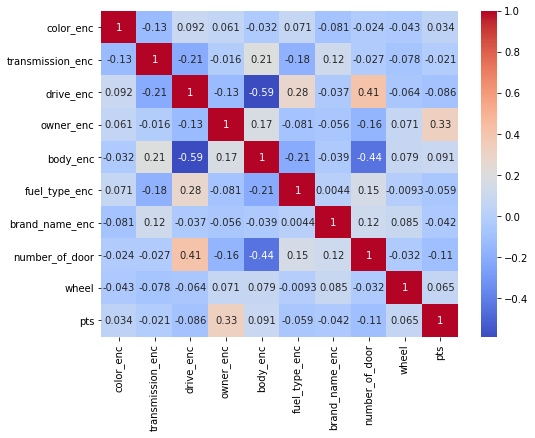

In [124]:
#Проверим корреляционную зависимость категориальных и бинарных переменных 
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(df_work[cat_cols_enc].corr(method = 'spearman'),annot = True, cmap = 'coolwarm')

Из корреляционного анализа видно, что наибольшая взаимосвязь существует между данными в столбцах "body_enc", "number_of_door" и "drive_enc". Это связано с тем, что все эти характеристики привязаны к типу кузова. Если это седан, то скорее всего у него будет 4 двери и он будет переднеприводный. Основным признаком будет столбец "body_enc".

<AxesSubplot:>

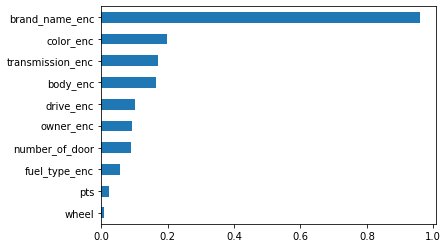

In [125]:
#Значимость категориальных переменных
imp_cat = pd.Series(mutual_info_classif(df_work[cat_cols_enc], df_work['price'], discrete_features =True), index = cat_cols_enc)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [126]:
#Статистический тест для категориальных переменных
data_stat = df_work[df_work['price'] != 0]

In [127]:
for col in cat_cols_enc:
    nominative_analysis(data_stat, col)

Найдены статистически значимые различия для колонки color_enc
Найдены статистически значимые различия для колонки transmission_enc
Найдены статистически значимые различия для колонки drive_enc
Найдены статистически значимые различия для колонки owner_enc
Найдены статистически значимые различия для колонки body_enc
Найдены статистически значимые различия для колонки fuel_type_enc
Найдены статистически значимые различия для колонки brand_name_enc
Найдены статистически значимые различия для колонки number_of_door
Найдены статистически значимые различия для колонки wheel
Найдены статистически значимые различия для колонки pts


#### Для обучения модели оставляем все признаки

### Работа с числовыми переменными

In [128]:
# Числовые переменные
num_cols = ['release', 'mileage', 'engine_displacement', 'engine_power']

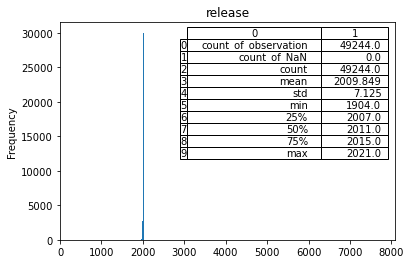

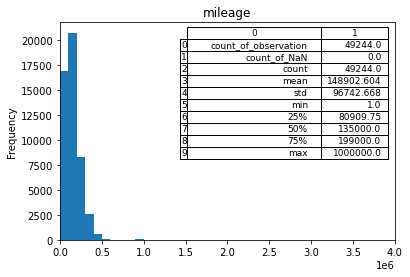

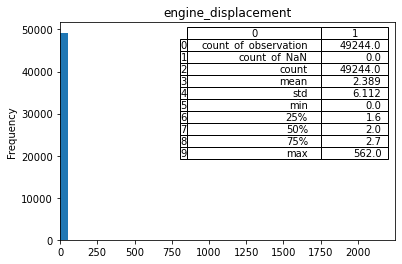

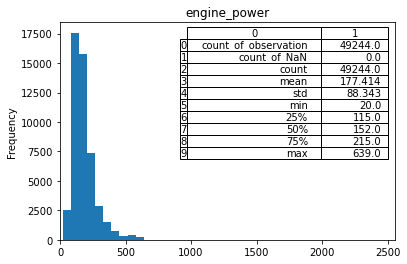

In [129]:
# Рассмотрим данные 
gist_draw(df_work[num_cols])

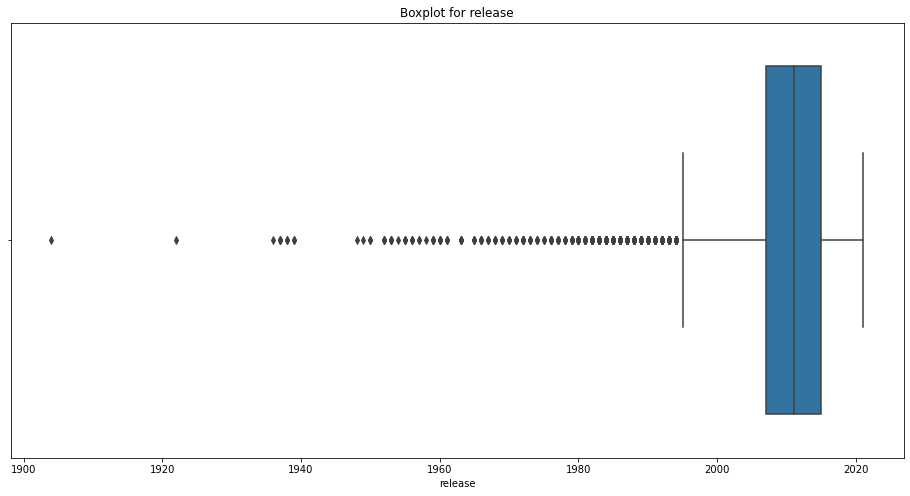

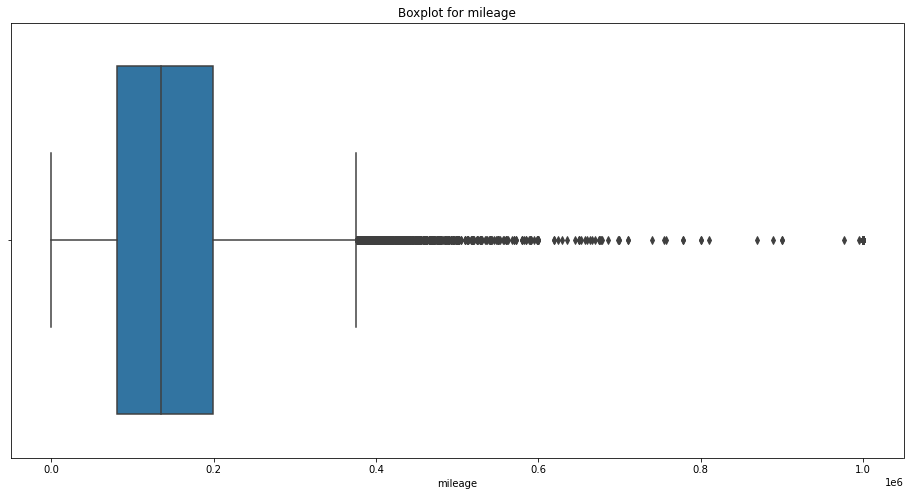

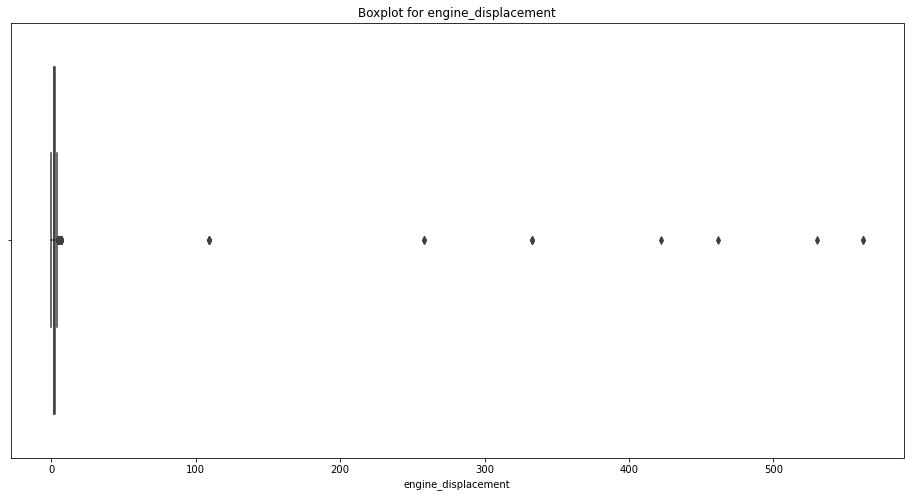

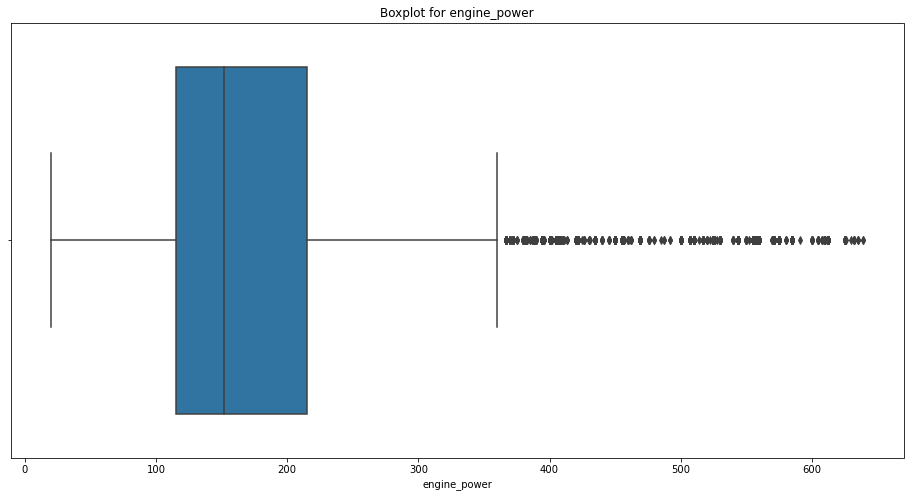

In [130]:
get_boxplot(df_work[num_cols])

Рассмотрим данные в столбце 'realise'. Назначим величину отсечения выбросов

In [131]:
#Посчитаем границу выброса с помощью межквартильного расстояния
expel_IQR_release = df_work['release'].quantile(0.25) - 1.5 * (df_work['release'].quantile(0.75) - df_work['release'].quantile(0.25))
expel_IQR_release

1995.0

In [132]:
df_work[df_work['release'] < expel_IQR_release]

,name,price,release,mileage,color,transmission,drive,wheel,owner,pts,brand,body,number_of_door,engine_displacement,engine_power,fuel_type,sample,single_name,brand_name,color_enc,transmission_enc,drive_enc,owner_enc,body_enc,fuel_type_enc,brand_name_enc
34,2121 (4x4) I,55000.0,1990.0,170000.0,красный,механическая,полный,0,3 или более,0,lada,внедорожник,3,1.6,75.0,бензин,1,2121,lada 2121,7.0,2.0,2.0,2.0,0.0,0.0,63.0
72,2121 (4x4) I,55000.0,1990.0,170000.0,красный,механическая,полный,0,3 или более,0,lada,внедорожник,3,1.6,75.0,бензин,1,2121,lada 2121,7.0,2.0,2.0,2.0,0.0,0.0,63.0
547,Sprinter Carib II,65000.0,1988.0,250000.0,красный,автоматическая,полный,1,3 или более,1,toyota,универсал,5,1.6,100.0,бензин,1,other,toyota other,7.0,0.0,2.0,2.0,17.0,0.0,155.0
553,2101 21013,57400.0,1985.0,98000.0,зелёный,механическая,задний,0,3 или более,0,lada,седан,4,1.2,64.0,бензин,1,other,lada other,4.0,2.0,0.0,2.0,14.0,0.0,67.0
658,2101,15000000.0,1972.0,62.0,синий,механическая,задний,0,1 владелец,0,lada,седан,4,1.2,64.0,бензин,1,other,lada other,13.0,2.0,0.0,0.0,14.0,0.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34592,CARINA,0.0,1988.0,300000.0,белый,автоматическая,передний,1,3 или более,1,toyota,седан,4,1.5,94.0,бензин,0,carina,toyota carina,1.0,0.0,1.0,2.0,14.0,0.0,142.0
34605,MARK_II,0.0,1994.0,300000.0,серебристый,автоматическая,задний,1,3 или более,1,toyota,седан,4,2.0,135.0,бензин,0,mark_ii,toyota mark_ii,11.0,0.0,0.0,2.0,14.0,0.0,154.0
34645,GS,0.0,1994.0,200000.0,серебристый,автоматическая,задний,0,3 или более,1,lexus,седан,4,3.0,212.0,бензин,0,gs,lexus gs,11.0,0.0,0.0,2.0,14.0,0.0,70.0
34652,3ER,0.0,1992.0,230000.0,чёрный,механическая,задний,0,3 или более,1,bmw,купе,2,2.0,150.0,бензин,0,3er,bmw 3er,15.0,2.0,0.0,2.0,4.0,0.0,11.0


Копейка 1972 года со стоимостью 15000000 и пробегом 62 км оставим как отсечную точку (не характерная переменная - раритет)

In [133]:
expel_release = 1972
df_work[df_work['release'] < expel_release]

,name,price,release,mileage,color,transmission,drive,wheel,owner,pts,brand,body,number_of_door,engine_displacement,engine_power,fuel_type,sample,single_name,brand_name,color_enc,transmission_enc,drive_enc,owner_enc,body_enc,fuel_type_enc,brand_name_enc
767,21 «Волга» 21В,21000000.0,1959.0,190.0,зелёный,механическая,задний,0,1 владелец,0,other,седан,4,2.5,70.0,бензин,1,other,other,4.0,2.0,0.0,0.0,14.0,0.0,126.0
802,69,190000.0,1960.0,55895.0,зелёный,механическая,полный,0,3 или более,1,other,внедорожник,3,2.1,55.0,бензин,1,other,other,4.0,2.0,2.0,2.0,0.0,0.0,126.0
877,69,100000.0,1955.0,50000.0,зелёный,механическая,полный,0,1 владелец,0,other,внедорожник,3,2.1,55.0,бензин,1,other,other,4.0,2.0,2.0,0.0,0.0,0.0,126.0
914,69 69А,80000.0,1971.0,100000.0,зелёный,механическая,полный,0,1 владелец,1,other,внедорожник,5,2.1,55.0,бензин,1,other,other,4.0,2.0,2.0,0.0,0.0,0.0,126.0
966,69 69А,40000.0,1970.0,100000.0,синий,механическая,полный,0,1 владелец,0,other,внедорожник,5,2.1,55.0,бензин,1,other,other,13.0,2.0,2.0,0.0,0.0,0.0,126.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18014,190_SL,0.0,1957.0,62300.0,пурпурный,механическая,задний,0,2 владельца,0,mercedes-benz,родстер,2,1.9,105.0,бензин,0,other,mercedes-benz other,9.0,2.0,0.0,1.0,13.0,0.0,88.0
18129,W128,0.0,1959.0,1000.0,коричневый,механическая,задний,0,1 владелец,0,mercedes-benz,купе,2,2.2,120.0,бензин,0,other,mercedes-benz other,6.0,2.0,0.0,0.0,4.0,0.0,88.0
18185,W188,0.0,1952.0,45200.0,золотистый,механическая,задний,0,1 владелец,0,mercedes-benz,купе,2,3.0,150.0,бензин,0,other,mercedes-benz other,5.0,2.0,0.0,0.0,4.0,0.0,88.0
24597,TYPE_1,0.0,1965.0,50000.0,синий,механическая,задний,0,2 владельца,0,volkswagen,кабриолет,2,1.3,40.0,бензин,0,other,volkswagen other,13.0,2.0,0.0,1.0,2.0,0.0,165.0


In [134]:
df_work[df_work['release'] == 1904]

,name,price,release,mileage,color,transmission,drive,wheel,owner,pts,brand,body,number_of_door,engine_displacement,engine_power,fuel_type,sample,single_name,brand_name,color_enc,transmission_enc,drive_enc,owner_enc,body_enc,fuel_type_enc,brand_name_enc
16944,SIMPLEX,0.0,1904.0,48000.0,белый,механическая,задний,1,1 владелец,0,mercedes-benz,кабриолет,0,5.3,32.0,бензин,0,other,mercedes-benz other,1.0,2.0,0.0,0.0,2.0,0.0,88.0


Столбец "release" оставим без изменений. 

Заменим признак 'release' (год выпуска) на 'exploitation_period' (срок эксплуатации) 

In [135]:
df_work['exploitation_period'] = df_work['release'].apply(lambda x: 2021 - x)

In [136]:
# учтем в списке переменных
num_cols = ['exploitation_period', 'mileage', 'engine_displacement', 'engine_power']

Рассмотрим данные в столбце mileage

In [137]:
expel_IQR_mileage = df_work['mileage'].quantile(0.75) + 1.5 * (df_work['mileage'].quantile(0.75) - df_work['mileage'].quantile(0.25))
expel_IQR_mileage

376135.375

In [138]:
df_work[df_work['mileage'] > expel_IQR_mileage]

,name,price,release,mileage,color,transmission,drive,wheel,owner,pts,brand,body,number_of_door,engine_displacement,engine_power,fuel_type,sample,single_name,brand_name,color_enc,transmission_enc,drive_enc,owner_enc,body_enc,fuel_type_enc,brand_name_enc,exploitation_period
30,XC90 I Рестайлинг,749856.0,2008.0,380000.0,коричневый,автоматическая,полный,0,1 владелец,0,volvo,внедорожник,5,3.2,238.0,бензин,1,xc90,volvo xc90,6.0,0.0,2.0,0.0,0.0,0.0,177.0,13.0
68,XC90 I Рестайлинг,749856.0,2008.0,380000.0,коричневый,автоматическая,полный,0,1 владелец,0,volvo,внедорожник,5,3.2,238.0,бензин,1,xc90,volvo xc90,6.0,0.0,2.0,0.0,0.0,0.0,177.0,13.0
886,Tahoe I,365000.0,1996.0,380000.0,синий,автоматическая,полный,0,3 или более,1,chevrolet,внедорожник,5,5.7,203.0,бензин,1,other,chevrolet other,13.0,0.0,2.0,2.0,0.0,0.0,25.0,25.0
898,Priora I Рестайлинг,195000.0,2013.0,377000.0,белый,механическая,передний,0,1 владелец,0,lada,седан,4,1.6,98.0,бензин,1,priora,lada priora,1.0,2.0,1.0,0.0,14.0,0.0,68.0,8.0
957,Windom I (XV10),185000.0,1993.0,462358.0,зелёный,автоматическая,передний,1,3 или более,0,toyota,седан,4,2.5,175.0,бензин,1,other,toyota other,4.0,0.0,1.0,2.0,14.0,0.0,155.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34484,ALMERA,0.0,2001.0,391166.0,серый,автоматическая,передний,0,3 или более,0,nissan,седан,4,1.8,114.0,бензин,0,almera,nissan almera,12.0,0.0,1.0,2.0,14.0,0.0,104.0,20.0
34521,ALMERA,0.0,1998.0,450000.0,зелёный,механическая,передний,0,3 или более,1,nissan,седан,4,1.4,75.0,бензин,0,almera,nissan almera,4.0,2.0,1.0,2.0,14.0,0.0,104.0,23.0
34553,CRESTA,0.0,1994.0,500000.0,белый,автоматическая,задний,1,3 или более,1,toyota,седан,4,2.5,97.0,дизель,0,other,toyota other,1.0,0.0,0.0,2.0,14.0,3.0,155.0,27.0
34618,COROLLA,0.0,1997.0,547865.0,жёлтый,механическая,передний,0,3 или более,0,toyota,универсал,5,1.6,110.0,бензин,0,corolla,toyota corolla,3.0,2.0,1.0,2.0,17.0,0.0,145.0,24.0


In [139]:
df_work[df_work['mileage'] == 1000000]

,name,price,release,mileage,color,transmission,drive,wheel,owner,pts,brand,body,number_of_door,engine_displacement,engine_power,fuel_type,sample,single_name,brand_name,color_enc,transmission_enc,drive_enc,owner_enc,body_enc,fuel_type_enc,brand_name_enc,exploitation_period
12249,24 «Волга» I (24) 2407,70000.0,1973.0,1000000.0,зелёный,механическая,задний,0,2 владельца,0,other,седан,4,2.5,85.0,бензин,1,other,other,4.0,2.0,0.0,1.0,14.0,0.0,126.0,48.0
4647,80,0.0,1990.0,1000000.0,серый,механическая,передний,0,3 или более,1,audi,седан,4,1.8,90.0,бензин,0,80,audi 80,12.0,2.0,1.0,2.0,14.0,0.0,0.0,31.0
6568,240_SERIES,0.0,1978.0,1000000.0,голубой,механическая,задний,0,3 или более,0,volvo,седан,4,2.0,90.0,бензин,0,other,volvo other,2.0,2.0,0.0,2.0,14.0,0.0,171.0,43.0
9463,7ER,0.0,1989.0,1000000.0,чёрный,механическая,задний,0,1 владелец,1,bmw,седан,4,3.0,188.0,бензин,0,7er,bmw 7er,15.0,2.0,0.0,0.0,14.0,0.0,14.0,32.0
9888,5ER,0.0,1989.0,1000000.0,серый,механическая,задний,0,3 или более,1,bmw,седан,4,2.0,129.0,бензин,0,5er,bmw 5er,12.0,2.0,0.0,2.0,14.0,0.0,13.0,32.0
17203,W124,0.0,1987.0,1000000.0,бежевый,механическая,задний,0,3 или более,0,mercedes-benz,седан,4,2.3,136.0,бензин,0,other,mercedes-benz other,0.0,2.0,0.0,2.0,14.0,0.0,88.0,34.0
18308,S_KLASSE,0.0,1991.0,1000000.0,серый,автоматическая,задний,0,3 или более,1,mercedes-benz,седан,4,4.2,286.0,бензин,0,s_klasse,mercedes-benz s_klasse,12.0,0.0,0.0,2.0,14.0,0.0,89.0,30.0
20164,COROLLA_LEVIN,0.0,1993.0,1000000.0,чёрный,механическая,передний,1,3 или более,1,toyota,купе,2,1.6,115.0,бензин,0,other,toyota other,15.0,2.0,1.0,2.0,4.0,0.0,155.0,28.0
21459,LAND_CRUISER,0.0,1994.0,1000000.0,пурпурный,автоматическая,полный,0,3 или более,1,toyota,внедорожник,5,4.2,165.0,дизель,0,land_cruiser,toyota land_cruiser,9.0,0.0,2.0,2.0,0.0,3.0,152.0,27.0
25168,TRANSPORTER,0.0,1984.0,1000000.0,белый,автоматическая,задний,0,1 владелец,1,volkswagen,минивэн,3,2.1,112.0,бензин,0,transporter,volkswagen transporter,1.0,0.0,0.0,0.0,9.0,0.0,170.0,37.0


Оставим значения без изменений

Данные в столбце "engine_displacement"

In [140]:
#Посчитаем границу выброса с помощью межквартильного расстояния
expel_IQR_displacement = df_work['engine_displacement'].quantile(0.75) + 1.5 * (df_work['engine_displacement'].quantile(0.75) - df_work['engine_displacement'].quantile(0.25))
expel_IQR_displacement

4.3500000000000005

In [141]:
df_work[df_work['engine_displacement'] > expel_IQR_displacement]

,name,price,release,mileage,color,transmission,drive,wheel,owner,pts,brand,body,number_of_door,engine_displacement,engine_power,fuel_type,sample,single_name,brand_name,color_enc,transmission_enc,drive_enc,owner_enc,body_enc,fuel_type_enc,brand_name_enc,exploitation_period
2,GL-Класс II (X166) 500,2690000.0,2012.0,226000.0,чёрный,автоматическая,полный,0,1 владелец,0,mercedes-benz,внедорожник,5,4.7,435.0,бензин,1,other,mercedes-benz other,15.0,0.0,2.0,0.0,0.0,0.0,88.0,9.0
3,Tahoe IV,3385000.0,2016.0,37000.0,чёрный,автоматическая,полный,0,2 владельца,0,chevrolet,внедорожник,5,6.2,409.0,бензин,1,other,chevrolet other,15.0,0.0,2.0,1.0,0.0,0.0,25.0,5.0
41,Tahoe IV,3385000.0,2016.0,37000.0,чёрный,автоматическая,полный,0,2 владельца,0,chevrolet,внедорожник,5,6.2,409.0,бензин,1,other,chevrolet other,15.0,0.0,2.0,1.0,0.0,0.0,25.0,5.0
97,GL-Класс II (X166) 500,2680000.0,2014.0,98000.0,синий,автоматическая,полный,0,2 владельца,0,mercedes-benz,внедорожник,5,4.7,435.0,бензин,1,other,mercedes-benz other,13.0,0.0,2.0,1.0,0.0,0.0,88.0,7.0
102,6 серии II (E63/E64) 645i,650000.0,2005.0,160000.0,серебристый,автоматическая,задний,0,3 или более,0,bmw,купе,2,4.4,333.0,бензин,1,other,bmw other,11.0,0.0,0.0,2.0,4.0,0.0,15.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34642,LX,0.0,2011.0,484000.0,чёрный,автоматическая,полный,0,1 владелец,0,lexus,внедорожник,5,5.7,367.0,бензин,0,lx,lexus lx,15.0,0.0,2.0,0.0,0.0,0.0,71.0,10.0
34662,5ER,0.0,2010.0,191000.0,бежевый,автоматическая,задний,0,2 владельца,0,bmw,седан,4,4.4,407.0,бензин,0,5er,bmw 5er,0.0,0.0,0.0,1.0,14.0,0.0,13.0,11.0
34670,X5,0.0,2005.0,250000.0,чёрный,автоматическая,полный,0,3 или более,1,bmw,внедорожник,5,4.4,320.0,бензин,0,x5,bmw x5,15.0,0.0,2.0,2.0,0.0,0.0,18.0,16.0
34673,7ER,0.0,2005.0,239000.0,чёрный,автоматическая,задний,0,1 владелец,0,bmw,седан,4,4.8,367.0,бензин,0,7er,bmw 7er,15.0,0.0,0.0,0.0,14.0,0.0,14.0,16.0


In [142]:
#назначим границу отсечения
expel_displacement = 6.8

In [143]:
df_work[df_work['engine_displacement'] > expel_displacement]

,name,price,release,mileage,color,transmission,drive,wheel,owner,pts,brand,body,number_of_door,engine_displacement,engine_power,fuel_type,sample,single_name,brand_name,color_enc,transmission_enc,drive_enc,owner_enc,body_enc,fuel_type_enc,brand_name_enc,exploitation_period
3785,Taycan I 4S,11150000.0,2020.0,169.0,серый,автоматическая,полный,0,3 или более,0,other,седан,4,530.0,390.0,электро,1,other,other,12.0,0.0,2.0,2.0,14.0,4.0,126.0,1.0
3926,Model S I P85,3333000.0,2013.0,107500.0,серый,автоматическая,задний,0,3 или более,0,other,лифтбек,5,422.0,310.0,электро,1,other,other,12.0,0.0,0.0,2.0,7.0,4.0,126.0,8.0
4057,Model 3 I Standart,3500000.0,2019.0,12500.0,чёрный,автоматическая,задний,0,1 владелец,0,other,седан,4,258.0,190.0,электро,1,other,other,15.0,0.0,0.0,0.0,14.0,4.0,126.0,2.0
4303,Leaf I (ZE0/AZE0),730000.0,2011.0,55000.0,белый,автоматическая,передний,0,1 владелец,0,nissan,хэтчбек,5,109.0,80.0,электро,1,other,nissan other,1.0,0.0,1.0,0.0,20.0,4.0,111.0,10.0
4815,Leaf I (ZE0/AZE0),899000.0,2014.0,80637.0,голубой,автоматическая,передний,0,1 владелец,0,nissan,хэтчбек,5,109.0,80.0,электро,1,other,nissan other,2.0,0.0,1.0,0.0,20.0,4.0,111.0,7.0
5307,Leaf I (ZE0/AZE0) 30kWh,1290000.0,2016.0,19500.0,серый,автоматическая,передний,0,1 владелец,0,nissan,хэтчбек,5,109.0,80.0,электро,1,other,nissan other,12.0,0.0,1.0,0.0,20.0,4.0,111.0,5.0
7275,Model S I Рестайлинг 70D,3599000.0,2016.0,37500.0,чёрный,автоматическая,полный,0,1 владелец,0,other,лифтбек,5,333.0,245.0,электро,1,other,other,15.0,0.0,2.0,0.0,7.0,4.0,126.0,5.0
7317,Model 3 I Standart,3650000.0,2020.0,7150.0,белый,автоматическая,задний,0,1 владелец,0,other,седан,4,258.0,190.0,электро,1,other,other,1.0,0.0,0.0,0.0,14.0,4.0,126.0,1.0
7321,Model S I Рестайлинг 70D,3599000.0,2016.0,37500.0,чёрный,автоматическая,полный,0,1 владелец,0,other,лифтбек,5,333.0,245.0,электро,1,other,other,15.0,0.0,2.0,0.0,7.0,4.0,126.0,5.0
7564,Model 3 I Performance,6095000.0,2020.0,15.0,белый,автоматическая,полный,0,1 владелец,0,other,седан,4,462.0,340.0,электро,1,other,other,1.0,0.0,2.0,0.0,14.0,4.0,126.0,1.0


Видем, что для электромобилей значения объема двигателя уходит за 100. Это значит что для электромобиля тут представлена другая характеристика. Заменим величину на 0 

In [144]:
df_work['engine_displacement'] = df_work['engine_displacement'].apply(lambda x : 0 if x > 6.8 else x)

Данные в столбце "engine_power"

In [145]:
#Посчитаем границу выброса с помощью межквартильного расстояния
expel_IQR_power = df_work['engine_power'].quantile(0.75) + 1.5 * (df_work['engine_power'].quantile(0.75) - df_work['engine_power'].quantile(0.25))
expel_IQR_power

365.0

In [146]:
df_work[df_work['engine_power'] > expel_IQR_power]

,name,price,release,mileage,color,transmission,drive,wheel,owner,pts,brand,body,number_of_door,engine_displacement,engine_power,fuel_type,sample,single_name,brand_name,color_enc,transmission_enc,drive_enc,owner_enc,body_enc,fuel_type_enc,brand_name_enc,exploitation_period
2,GL-Класс II (X166) 500,2690000.0,2012.0,226000.0,чёрный,автоматическая,полный,0,1 владелец,0,mercedes-benz,внедорожник,5,4.7,435.0,бензин,1,other,mercedes-benz other,15.0,0.0,2.0,0.0,0.0,0.0,88.0,9.0
3,Tahoe IV,3385000.0,2016.0,37000.0,чёрный,автоматическая,полный,0,2 владельца,0,chevrolet,внедорожник,5,6.2,409.0,бензин,1,other,chevrolet other,15.0,0.0,2.0,1.0,0.0,0.0,25.0,5.0
41,Tahoe IV,3385000.0,2016.0,37000.0,чёрный,автоматическая,полный,0,2 владельца,0,chevrolet,внедорожник,5,6.2,409.0,бензин,1,other,chevrolet other,15.0,0.0,2.0,1.0,0.0,0.0,25.0,5.0
97,GL-Класс II (X166) 500,2680000.0,2014.0,98000.0,синий,автоматическая,полный,0,2 владельца,0,mercedes-benz,внедорожник,5,4.7,435.0,бензин,1,other,mercedes-benz other,13.0,0.0,2.0,1.0,0.0,0.0,88.0,7.0
199,GLE Coupe AMG I (C292) 63 AMG S,4999000.0,2017.0,74223.0,чёрный,автоматическая,полный,0,2 владельца,0,mercedes-benz,внедорожник,5,5.5,585.0,бензин,1,other,mercedes-benz other,15.0,0.0,2.0,1.0,0.0,0.0,88.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34641,LS,0.0,2008.0,198000.0,чёрный,вариатор,полный,0,3 или более,0,lexus,седан,4,5.0,394.0,гибрид,0,other,lexus other,15.0,1.0,2.0,2.0,14.0,2.0,72.0,13.0
34642,LX,0.0,2011.0,484000.0,чёрный,автоматическая,полный,0,1 владелец,0,lexus,внедорожник,5,5.7,367.0,бензин,0,lx,lexus lx,15.0,0.0,2.0,0.0,0.0,0.0,71.0,10.0
34662,5ER,0.0,2010.0,191000.0,бежевый,автоматическая,задний,0,2 владельца,0,bmw,седан,4,4.4,407.0,бензин,0,5er,bmw 5er,0.0,0.0,0.0,1.0,14.0,0.0,13.0,11.0
34673,7ER,0.0,2005.0,239000.0,чёрный,автоматическая,задний,0,1 владелец,0,bmw,седан,4,4.8,367.0,бензин,0,7er,bmw 7er,15.0,0.0,0.0,0.0,14.0,0.0,14.0,16.0


In [147]:
#назначим границу отсечения
expel_power = 632

In [148]:
df_work[df_work['engine_power'] > expel_power]

,name,price,release,mileage,color,transmission,drive,wheel,owner,pts,brand,body,number_of_door,engine_displacement,engine_power,fuel_type,sample,single_name,brand_name,color_enc,transmission_enc,drive_enc,owner_enc,body_enc,fuel_type_enc,brand_name_enc,exploitation_period
4366,Continental GT II Speed,6800000.0,2014.0,51700.0,белый,автоматическая,полный,0,1 владелец,0,other,купе,2,6.0,635.0,бензин,1,other,other,1.0,0.0,2.0,0.0,4.0,0.0,126.0,7.0
4577,Continental GT III,18777000.0,2019.0,3095.0,белый,роботизированная,полный,0,3 или более,0,other,купе,2,6.0,635.0,бензин,1,other,other,1.0,3.0,2.0,2.0,4.0,0.0,126.0,2.0
6504,AMG GT I Рестайлинг 63 S,11000000.0,2019.0,28500.0,серый,роботизированная,полный,0,1 владелец,0,mercedes-benz,лифтбек,5,4.0,639.0,бензин,1,other,mercedes-benz other,12.0,3.0,2.0,0.0,7.0,0.0,88.0,2.0
7103,Continental GT III,16950000.0,2018.0,23000.0,фиолетовый,роботизированная,полный,0,1 владелец,0,other,купе,2,6.0,635.0,бензин,1,other,other,14.0,3.0,2.0,0.0,4.0,0.0,126.0,3.0
15865,AMG_GT,0.0,2019.0,5116.0,серый,роботизированная,полный,0,1 владелец,0,mercedes-benz,лифтбек,5,4.0,639.0,бензин,0,other,mercedes-benz other,12.0,3.0,2.0,0.0,7.0,0.0,88.0,2.0


Оставим данные без изменения

/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


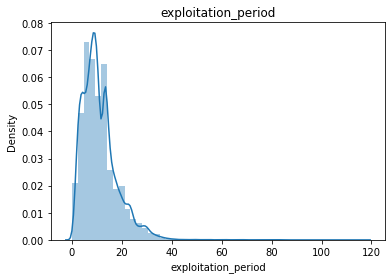

/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


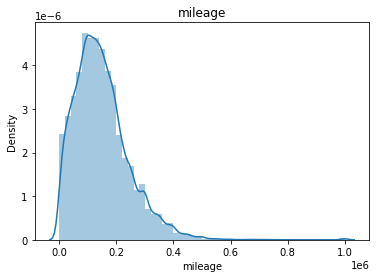

/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


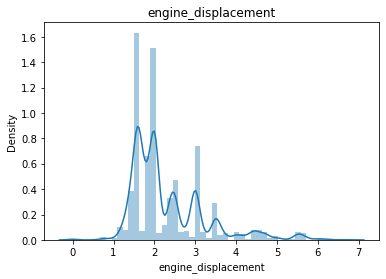

/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


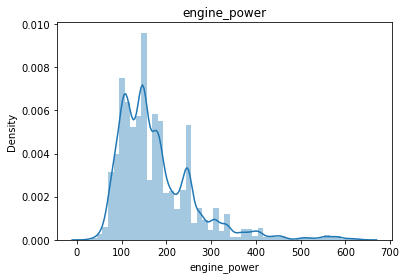

In [149]:
for i in df_work[num_cols]:
    plt.figure()
    sns.distplot(df_work[i], kde = True, rug = False)
    plt.title(i)
    plt.show()

Распределение числовых переменных имеет тяжелый правый хвост. Прологарифмируем числовые переменные

/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


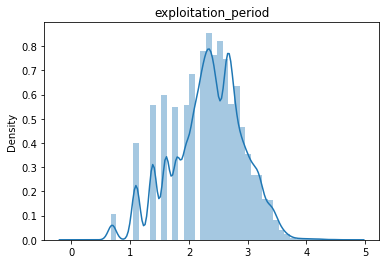

/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


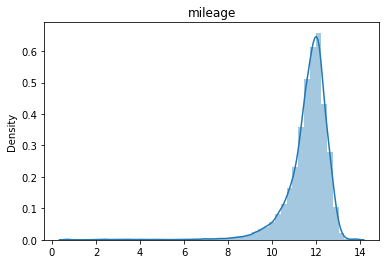

/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


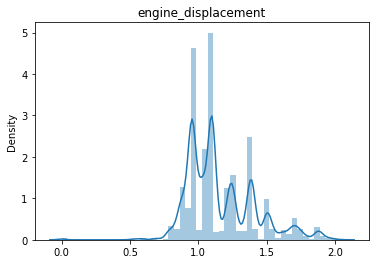

/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


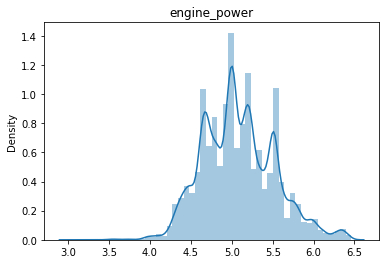

In [150]:
for i in df_work[num_cols]:
    arr_log = np.log(np.array(df_work[i])+1)
    plt.figure()
    sns.distplot(arr_log, kde = True, rug = False)
    plt.title(i)
    plt.show()

Распределение данных в столбцах 'exploitation_period', 'engine_displacement', 'engine_power' приблизилось к нормальному закону распределения

In [151]:
df_work['engine_displacement'] = df_work['engine_displacement'].apply(lambda x : np.log(x+1))
df_work['exploitation_period'] = df_work['exploitation_period'].apply(lambda x : np.log(x+1))
df_work['engine_power'] = df_work['engine_power'].apply(lambda x : np.log(x+1))

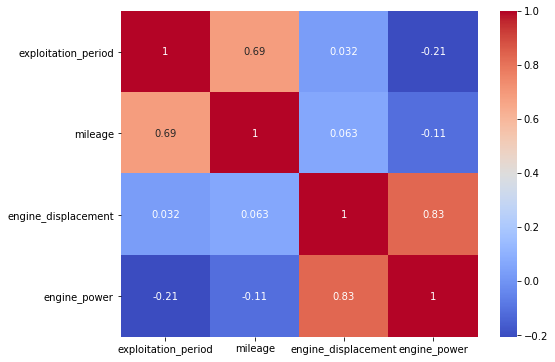

In [152]:
#Корреляционная зависимость числовых переменных
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(df_work[num_cols].corr(),annot = True, cmap = 'coolwarm')

Существует корреляционная зависимость между данными в следующих столбцах:

    1. 'engine_displacement' и 'engine_power' - чем больше объем, тем больше мощность;
    2. 'mileage' и 'exploitation_period' - чем больше срок эксплоатации, тем больше пробег

In [153]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49244 entries, 0 to 34685
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 49244 non-null  object 
 1   price                49244 non-null  float64
 2   release              49244 non-null  float64
 3   mileage              49244 non-null  float64
 4   color                49244 non-null  object 
 5   transmission         49244 non-null  object 
 6   drive                49244 non-null  object 
 7   wheel                49244 non-null  int64  
 8   owner                49244 non-null  object 
 9   pts                  49244 non-null  int64  
 10  brand                49244 non-null  object 
 11  body                 49244 non-null  object 
 12  number_of_door       49244 non-null  int64  
 13  engine_displacement  49244 non-null  float64
 14  engine_power         49244 non-null  float64
 15  fuel_type            49244 non-null 

num_cols = ['exploitation_period', 'mileage', 'engine_displacement', 'engine_power']

<AxesSubplot:>

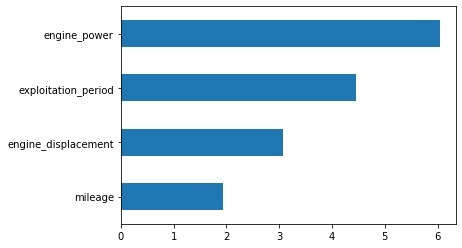

In [154]:
#Значимость числовых переменных
imp_num = pd.Series(f_classif(df_work[num_cols], df_work['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Подготовка данных

In [155]:
#DataFrame для обучения модели
name_columns = num_cols + cat_cols_enc
name_columns.append('price')
name_columns.append('sample')

In [156]:
df = df_work[name_columns].copy()

In [157]:
df.head(2)

,exploitation_period,mileage,engine_displacement,engine_power,color_enc,transmission_enc,drive_enc,owner_enc,body_enc,fuel_type_enc,brand_name_enc,number_of_door,wheel,pts,price,sample
0,1.945910,110000.0,1.098612,5.356586,12.0,0.0,2.0,0.0,0.0,0.0,88.0,5,0,0,1610000.0,1
1,2.079442,101500.0,1.252763,5.204007,15.0,0.0,1.0,2.0,14.0,0.0,141.0,4,0,0,1490000.0,1


In [158]:
#Категориальные переменные для кодирования
categorial_cols = ['color_enc', 'transmission_enc', 'drive_enc', 'owner_enc', 'body_enc', 'fuel_type_enc', 'brand_name_enc']
bin_cols = ['number_of_door', 'wheel', 'pts']

#### Категориальные признаки

In [159]:
df_dummies = pd.DataFrame(OneHotEncoder(sparse = False).fit_transform(df[categorial_cols]))

In [160]:
df = df.drop(categorial_cols, axis = 1)

In [161]:
df.shape

(49244, 9)

In [162]:
df_dummies.shape

(49244, 230)

In [163]:
df = df.join(df_dummies)
df.shape

(49244, 239)

#### Числовые переменные

In [164]:
df_num = pd.DataFrame(StandardScaler().fit_transform(df[num_cols].values), columns = num_cols)

In [165]:
df = df.drop(num_cols, axis = 1)

In [166]:
df = df.join(df_num)
df.shape

(49244, 239)

In [167]:
#Выделим тестовую часть из df
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

In [168]:
X = train_data.drop(['price'], axis = 1).values
X_test = test_data.drop(['price'], axis = 1).values

In [169]:
X.shape

(14558, 237)

In [170]:
X_test.shape

(34686, 237)

In [171]:
y = train_data['price'].values 

In [172]:
y.shape

(14558,)

# Обучение модели

In [173]:
#разделим данные в данных для обучения
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [174]:
X_train.shape

(11646, 237)

In [175]:
X_val.shape

(2912, 237)

In [176]:
y_train.shape

(11646,)

In [177]:
y_val.shape

(2912,)

In [178]:
#генерируем фолды (KFold)
cv = KFold(n_splits=10, shuffle=True, random_state = RANDOM_SEED)

In [179]:
# Стекинг (получение новых значений числовых переменных)
stacked_features_train, stacked_features_test = generate_meta_features([
    LinearRegression(normalize = True),
    KNeighborsRegressor(),
    ExtraTreesRegressor(random_state = RANDOM_SEED), 
    AdaBoostRegressor(random_state = RANDOM_SEED)
], X_train, X_val, y_train, cv)

100%|██████████| 4/4 [04:51<00:00, 72.93s/it] 


In [180]:
stacked_features_train.shape

(4, 11646)

In [181]:
stacked_features_train

array([[ 802944. , 1015808. , 1421312. , ..., 1351680. ,  825728. ,
        1401856. ],
       [ 507600. ,  920478. , 1079800. , ..., 1042800. ,  469800. ,
        1723000. ],
       [ 524120. ,  543847.6, 1879594.5, ...,  818570. ,  618176. ,
        1896100.5],
       [1900215.5, 1744789.4, 3968782. , ..., 2978268. , 1838739.5,
        3470821.5]], dtype=float32)

In [182]:
stacked_features_test.shape

(4, 2912)

In [183]:
stacked_features_test

array([[1490944.        ,  251904.        ,  874496.        , ...,
        1286144.        , 1159168.        , 1112064.        ],
       [1617571.4       , 1671600.        ,  926000.        , ...,
        1203200.        , 1375800.        ,  400200.        ],
       [2392560.        ,  184909.99      ,  726770.22      , ...,
         710800.37      , 1346500.        ,  380110.        ],
       [5797621.99385666, 1927455.34509381, 2104974.26611053, ...,
        1927455.34509381, 2104974.26611053, 4794397.3577072 ]])

In [184]:
#Агрегация ответов модели
clf = LinearRegression()

In [185]:
# Метрика
compute_metric(clf, stacked_features_train.T, y_train, stacked_features_test.T, y_val)    

2.383358

### Стекинг c помощью StackingRegressor

In [186]:
estimators = [
    ('lr', LinearRegression(normalize = True)),
    ('kn', KNeighborsRegressor()),
    ('etr', ExtraTreesRegressor(random_state = RANDOM_SEED)), 
    ('abr', AdaBoostRegressor(random_state = RANDOM_SEED))
             ]

In [187]:
stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=LinearRegression())

In [188]:
stacking_regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression(normalize=True)),
                              ('kn', KNeighborsRegressor()),
                              ('etr', ExtraTreesRegressor(random_state=42)),
                              ('abr', AdaBoostRegressor(random_state=42))],
                  final_estimator=LinearRegression())

In [189]:
y_st_pred = stacking_regressor.predict(X_val)

In [190]:
#Метрика
print(np.round( mean_absolute_percentage_error(y_val, y_st_pred), 6))

2.345599


С помощью stacking_regressor метрика получилась лучше

# Submission

In [191]:
sample_submission = pd.read_csv('sample_submission.csv')

In [192]:
sample_submission.head(2)

,sell_id,price
0,1100575026,0
1,1100549428,0


In [193]:
sample_submission.shape

(34686, 2)

In [194]:
predict_submission = stacking_regressor.predict(X_test)

In [195]:
predict_submission.shape

(34686,)

In [196]:
submit = pd.DataFrame(df_test_baza.sell_id)

In [198]:
submit['price'] = predict_submission

In [199]:
submit.head(2)

,sell_id,price
0,1100575026,1.309077e+06
1,1100549428,1.190898e+06


In [200]:
submit.to_csv('submission.csv', index=False)